In [7]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [8]:
base_dir = "DataSet"  # Replace with the actual path to your enron_spam folder
enron_folders = [
    os.path.join(base_dir, f"enron{i}") for i in range(1, 7)
]

In [9]:
def load_and_preprocess_data(folders):
    data = []
    for folder in folders:
        for label_type in ["ham", "spam"]:
            label = 0 if label_type == "ham" else 1
            label_dir = os.path.join(folder, label_type)
            for filename in os.listdir(label_dir):
                try:
                    with open(os.path.join(label_dir, filename), "r", encoding="latin-1") as file:
                        content = file.read()
                        content = re.sub('<[^<]+?>', '', content)
                        content = re.sub(r'\n+', ' ', content)
                        content = content.strip()
                        data.append([content, label])
                except Exception as e:
                    print(f"Error reading {filename}: {e}")
    df = pd.DataFrame(data, columns=["text", "label"])
    return df

In [ ]:
df = load_and_preprocess_data(enron_folders)

In [8]:
MAX_WORDS = 10000  # Maximum number of words to keep in the vocabulary
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
tokenizer.fit_on_texts(df['text'])

In [9]:
sequences = tokenizer.texts_to_sequences(df['text'])

In [10]:
MAX_LEN = 128  # Maximum length of the sequences after padding
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
labels = np.array(df['label'])

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

In [12]:
EMBEDDING_DIM = 100
LSTM_UNITS = 64

model = Sequential([
    Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(LSTM_UNITS, return_sequences=True), # Return sequences to stack another LSTM if needed
    LSTM(LSTM_UNITS),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 128, 64)           42240     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,075,329
Trainable params: 1,075,329
Non-trainable params: 0
_________________________________________________________________


In [15]:
EPOCHS = 10  # You can adjust the number of epochs
BATCH_SIZE = 32

history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val))

Epoch 1/10
843/843 [==============================] - 125s 148ms/step - loss: 0.0582 - accuracy: 0.9851 - val_loss: 0.0407 - val_accuracy: 0.9871
Epoch 2/10
843/843 [==============================] - 125s 148ms/step - loss: 0.0391 - accuracy: 0.9898 - val_loss: 0.0409 - val_accuracy: 0.9841
Epoch 3/10
843/843 [==============================] - 125s 148ms/step - loss: 0.0305 - accuracy: 0.9927 - val_loss: 0.0559 - val_accuracy: 0.9816
Epoch 4/10
843/843 [==============================] - 125s 148ms/step - loss: 0.0210 - accuracy: 0.9950 - val_loss: 0.0444 - val_accuracy: 0.9880
Epoch 5/10
843/843 [==============================] - 128s 151ms/step - loss: 0.0155 - accuracy: 0.9961 - val_loss: 0.0417 - val_accuracy: 0.9902
Epoch 6/10
843/843 [==============================] - 131s 155ms/step - loss: 0.0124 - accuracy: 0.9970 - val_loss: 0.0517 - val_accuracy: 0.9884
Epoch 7/10
843/843 [==============================] - 132s 156ms/step - loss: 0.0117 - accuracy: 0.9970 - val_loss: 0.0383 -

In [16]:
y_pred_probs = model.predict(X_val)
y_pred = np.round(y_pred_probs).astype(int)

print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

211/211 [==============================] - 7s 28ms/step
Accuracy: 0.9909535814919176
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3282
           1       0.99      1.00      0.99      3461

    accuracy                           0.99      6743
   macro avg       0.99      0.99      0.99      6743
weighted avg       0.99      0.99      0.99      6743



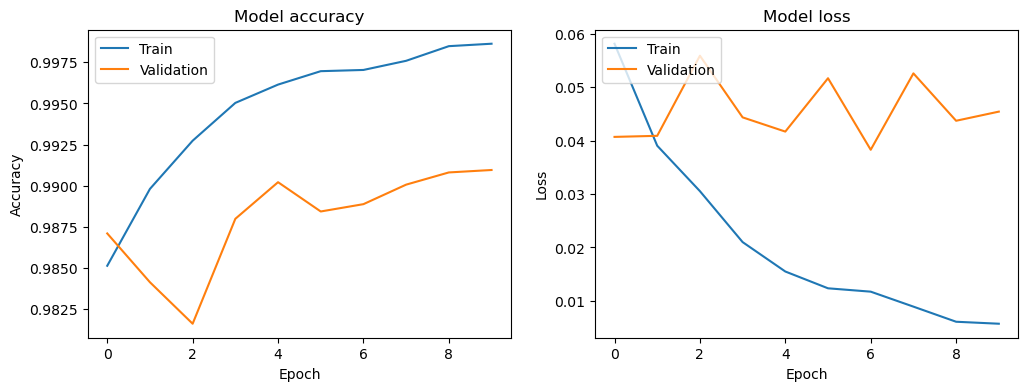

In [17]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [18]:
model_save_path = "enron_spam_lstm_model.h5"
model.save(model_save_path)
print(f"LSTM model saved to {model_save_path}")

# You might also want to save the tokenizer if you need to load the model later
import pickle
tokenizer_save_path = "enron_spam_lstm_tokenizer.pkl"
with open(tokenizer_save_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Tokenizer saved to {tokenizer_save_path}")

LSTM model saved to enron_spam_lstm_model.h5
Tokenizer saved to enron_spam_lstm_tokenizer.pkl


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Replace 'phishing_emails.csv' with the actual name of your downloaded file
new_df = pd.read_csv('DataSet/csv/Phishing_Email.csv')

# Display the first few rows to understand the structure
print(new_df.head())

   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  


In [3]:
import pickle

# Define the path to your saved tokenizer file
tokenizer_path = "model/enron_spam_lstm_tokenizer.pkl"

# Load the tokenizer
with open(tokenizer_path, 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

print("Tokenizer loaded successfully!") # Optional: Confirmation message

Tokenizer loaded successfully!


In [22]:
# Rename columns to be consistent (optional but good practice)
new_df.rename(columns={'Email Text': 'text', 'Email Type': 'label_text'}, inplace=True)

# Map labels to numerical values
new_df['label'] = new_df['label_text'].map({'Safe Email': 0, 'Phishing Email': 1})

# Handle potential NaN values in the text column
new_df.dropna(subset=['text', 'label'], inplace=True)

# Extract text and labels
new_texts = new_df['text'].tolist()
new_labels = new_df['label'].tolist()

# Tokenize the new texts using the loaded tokenizer
new_sequences = loaded_tokenizer.texts_to_sequences(new_texts)

# Pad the new sequences
new_padded_sequences = pad_sequences(new_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

new_labels = np.array(new_labels)

print("Shape of new padded sequences:", new_padded_sequences.shape)
print("Shape of new labels:", new_labels.shape)

Shape of new padded sequences: (18634, 128)
Shape of new labels: (18634,)


In [23]:
# Choose a smaller learning rate for fine-tuning (optional)
from tensorflow.keras.optimizers import Adam
new_learning_rate = 1e-5  # You can experiment with this value
model.optimizer.learning_rate.assign(new_learning_rate)

# Split the new data into training and validation sets (optional but recommended)
X_new_train, X_new_val, y_new_train, y_new_val = train_test_split(
    new_padded_sequences, new_labels, test_size=0.2, random_state=42
)

# Continue training the model
epochs_fine_tune = 5  # You can adjust the number of epochs
batch_size_fine_tune = 32 # You can adjust the batch size

history_fine_tune = model.fit(
    X_new_train, y_new_train,
    epochs=epochs_fine_tune,
    batch_size=batch_size_fine_tune,
    validation_data=(X_new_val, y_new_val)
)

Epoch 1/5
466/466 [==============================] - 169s 340ms/step - loss: 0.6900 - accuracy: 0.8657 - val_loss: 0.3731 - val_accuracy: 0.9074
Epoch 2/5
466/466 [==============================] - 158s 339ms/step - loss: 0.3433 - accuracy: 0.9055 - val_loss: 0.3016 - val_accuracy: 0.9096
Epoch 3/5
466/466 [==============================] - 159s 341ms/step - loss: 0.3063 - accuracy: 0.9058 - val_loss: 0.2770 - val_accuracy: 0.9115
Epoch 4/5
466/466 [==============================] - 159s 341ms/step - loss: 0.2862 - accuracy: 0.9051 - val_loss: 0.2606 - val_accuracy: 0.9152
Epoch 5/5
466/466 [==============================] - 158s 339ms/step - loss: 0.2651 - accuracy: 0.9059 - val_loss: 0.2426 - val_accuracy: 0.9184


In [24]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the new validation set
y_pred_probs_new = model.predict(X_new_val)
y_pred_new = np.round(y_pred_probs_new).astype(int)

print("Evaluation on the new validation set after fine-tuning:")
print("Accuracy:", accuracy_score(y_new_val, y_pred_new))
print(classification_report(y_new_val, y_pred_new))

117/117 [==============================] - 10s 85ms/step
Evaluation on the new validation set after fine-tuning:
Accuracy: 0.918433056077274
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2209
           1       0.89      0.91      0.90      1518

    accuracy                           0.92      3727
   macro avg       0.91      0.92      0.92      3727
weighted avg       0.92      0.92      0.92      3727



In [25]:
updated_model_save_path = "enron_spam_lstm_model_updated.h5"
model.save(updated_model_save_path)
print(f"Updated LSTM model saved to {updated_model_save_path}")

Updated LSTM model saved to enron_spam_lstm_model_updated.h5


In [26]:
from tensorflow.keras.models import load_model

# Replace 'path/to/your/backup/model.h5' with the actual path to your backup model file
backup_model_path = 'model/enron_spam_lstm_model.h5'

# Load the backup model
model = load_model(backup_model_path)

print("Successfully loaded the 99% accuracy backup model into the 'model' variable.")

Successfully loaded the 99% accuracy backup model into the 'model' variable.


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report

# --- Configuration ---
NEW_DATASET_FILENAME = 'Phishing-Email-Dataset/CEAS_08.csv'  # <--- REPLACE WITH THE ACTUAL FILENAME
TEXT_COLUMN = 'body'
LABEL_COLUMN = 'label'
MAX_LEN = 128  # Ensure this matches your previous setting
NEW_LEARNING_RATE = 1e-5  # You can experiment with this
EPOCHS_FINE_TUNE = 10      # Adjust as needed
BATCH_SIZE_FINE_TUNE = 32  # Adjust as needed

# --- Load the new dataset ---
try:
    new_df = pd.read_csv(NEW_DATASET_FILENAME)
    print(f"Loaded dataset: {NEW_DATASET_FILENAME} with {len(new_df)} samples.")
except FileNotFoundError:
    print(f"Error: File not found at path: {NEW_DATASET_FILENAME}")
    exit()

# --- Prepare the new data ---
if TEXT_COLUMN not in new_df.columns or LABEL_COLUMN not in new_df.columns:
    print(f"Error: '{TEXT_COLUMN}' or '{LABEL_COLUMN}' column not found in the dataset.")
    exit()

new_texts = new_df[TEXT_COLUMN].astype(str).tolist() # Ensure text is string
new_labels = new_df[LABEL_COLUMN].tolist()

# Tokenize the new texts using the loaded tokenizer
new_sequences = loaded_tokenizer.texts_to_sequences(new_texts)

# Pad the new sequences
new_padded_sequences = pad_sequences(new_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

new_labels = np.array(new_labels)

print("Shape of new padded sequences:", new_padded_sequences.shape)
print("Shape of new labels:", new_labels.shape)

# --- Split the new data for validation ---
X_new_train, X_new_val, y_new_train, y_new_val = train_test_split(
    new_padded_sequences, new_labels, test_size=0.2, random_state=42
)

print("Shape of new training data:", X_new_train.shape, y_new_train.shape)
print("Shape of new validation data:", X_new_val.shape, y_new_val.shape)

# --- Set the learning rate for fine-tuning ---
model.optimizer.learning_rate.assign(NEW_LEARNING_RATE)

# --- Continue training the model ---
print("\n--- Starting Fine-tuning ---")
history_fine_tune = model.fit(
    X_new_train, y_new_train,
    epochs=EPOCHS_FINE_TUNE,
    batch_size=BATCH_SIZE_FINE_TUNE,
    validation_data=(X_new_val, y_new_val)
)

# --- Evaluate the updated model on the new validation set ---
print("\n--- Evaluating on the new validation set ---")
y_pred_probs_new = model.predict(X_new_val)
y_pred_new = np.round(y_pred_probs_new).astype(int)

print("Accuracy:", accuracy_score(y_new_val, y_pred_new))
print(classification_report(y_new_val, y_pred_new))

# --- Optional: Save the updated model (you might want to use a new name) ---
updated_model_save_path = f"enron_spam_lstm_model_updated_{NEW_DATASET_FILENAME.replace('.csv', '')}.h5"
model.save(updated_model_save_path)
print(f"Updated LSTM model saved to {updated_model_save_path}")

Loaded dataset: Phishing-Email-Dataset/CEAS_08.csv with 39154 samples.
Shape of new padded sequences: (39154, 128)
Shape of new labels: (39154,)
Shape of new training data: (31323, 128) (31323,)
Shape of new validation data: (7831, 128) (7831,)

--- Starting Fine-tuning ---
Epoch 1/10
979/979 [==============================] - 193s 198ms/step - loss: 0.2092 - accuracy: 0.9266 - val_loss: 0.1671 - val_accuracy: 0.9420
Epoch 2/10
979/979 [==============================] - 194s 198ms/step - loss: 0.1886 - accuracy: 0.9352 - val_loss: 0.1536 - val_accuracy: 0.9466
Epoch 3/10
979/979 [==============================] - 193s 197ms/step - loss: 0.1767 - accuracy: 0.9402 - val_loss: 0.1442 - val_accuracy: 0.9494
Epoch 4/10
979/979 [==============================] - 196s 200ms/step - loss: 0.1659 - accuracy: 0.9442 - val_loss: 0.1373 - val_accuracy: 0.9522
Epoch 5/10
979/979 [==============================] - 197s 201ms/step - loss: 0.1556 - accuracy: 0.9474 - val_loss: 0.1308 - val_accuracy: 0.

In [1]:
from tensorflow.keras.models import load_model

# Replace 'path/to/your/backup/model.h5' with the actual path to your backup model file
backup_model_path = 'enron_spam_lstm_model_updated_Phishing-Email-Dataset/CEAS_08.h5'

# Load the backup model
model = load_model(backup_model_path)

print("Successfully loaded the 99% accuracy backup model into the 'model' variable.")

Successfully loaded the 99% accuracy backup model into the 'model' variable.


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report

# --- Configuration ---
NEW_DATASET_FILENAME = 'Phishing-Email-Dataset/Nazario.csv'  # <--- REPLACE WITH THE ACTUAL FILENAME
TEXT_COLUMN = 'body'
LABEL_COLUMN = 'label'
MAX_LEN = 128  # Ensure this matches your previous setting
NEW_LEARNING_RATE = 1e-5  # You can experiment with this
EPOCHS_FINE_TUNE = 20      # Adjust as needed
BATCH_SIZE_FINE_TUNE = 32  # Adjust as needed

# --- Load the new dataset ---
try:
    new_df = pd.read_csv(NEW_DATASET_FILENAME)
    print(f"Loaded dataset: {NEW_DATASET_FILENAME} with {len(new_df)} samples.")
except FileNotFoundError:
    print(f"Error: File not found at path: {NEW_DATASET_FILENAME}")
    exit()

# --- Prepare the new data ---
if TEXT_COLUMN not in new_df.columns or LABEL_COLUMN not in new_df.columns:
    print(f"Error: '{TEXT_COLUMN}' or '{LABEL_COLUMN}' column not found in the dataset.")
    exit()

new_texts = new_df[TEXT_COLUMN].astype(str).tolist() # Ensure text is string
new_labels = new_df[LABEL_COLUMN].tolist()

# Tokenize the new texts using the loaded tokenizer
new_sequences = loaded_tokenizer.texts_to_sequences(new_texts)

# Pad the new sequences
new_padded_sequences = pad_sequences(new_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

new_labels = np.array(new_labels)

print("Shape of new padded sequences:", new_padded_sequences.shape)
print("Shape of new labels:", new_labels.shape)

# --- Split the new data for validation ---
X_new_train, X_new_val, y_new_train, y_new_val = train_test_split(
    new_padded_sequences, new_labels, test_size=0.2, random_state=42
)

print("Shape of new training data:", X_new_train.shape, y_new_train.shape)
print("Shape of new validation data:", X_new_val.shape, y_new_val.shape)

# --- Set the learning rate for fine-tuning ---
model.optimizer.learning_rate.assign(NEW_LEARNING_RATE)

# --- Continue training the model ---
print("\n--- Starting Fine-tuning ---")
history_fine_tune = model.fit(
    X_new_train, y_new_train,
    epochs=EPOCHS_FINE_TUNE,
    batch_size=BATCH_SIZE_FINE_TUNE,
    validation_data=(X_new_val, y_new_val)
)

# --- Evaluate the updated model on the new validation set ---
print("\n--- Evaluating on the new validation set ---")
y_pred_probs_new = model.predict(X_new_val)
y_pred_new = np.round(y_pred_probs_new).astype(int)

print("Accuracy:", accuracy_score(y_new_val, y_pred_new))
print(classification_report(y_new_val, y_pred_new))

# --- Optional: Save the updated model (you might want to use a new name) ---
updated_model_save_path = f"enron_spam_lstm_model_updated_{NEW_DATASET_FILENAME.replace('.csv', '')}.h5"
model.save(updated_model_save_path)
print(f"Updated LSTM model saved to {updated_model_save_path}")

Loaded dataset: Phishing-Email-Dataset/Nazario.csv with 1565 samples.
Shape of new padded sequences: (1565, 128)
Shape of new labels: (1565,)
Shape of new training data: (1252, 128) (1252,)
Shape of new validation data: (313, 128) (313,)

--- Starting Fine-tuning ---
Epoch 1/20
40/40 [==============================] - 5s 117ms/step - loss: 0.2754 - accuracy: 0.8906 - val_loss: 0.3320 - val_accuracy: 0.8466
Epoch 2/20
40/40 [==============================] - 7s 179ms/step - loss: 0.2642 - accuracy: 0.8994 - val_loss: 0.3034 - val_accuracy: 0.8562
Epoch 3/20
40/40 [==============================] - 7s 168ms/step - loss: 0.2211 - accuracy: 0.9065 - val_loss: 0.2782 - val_accuracy: 0.8722
Epoch 4/20
40/40 [==============================] - 6s 160ms/step - loss: 0.2084 - accuracy: 0.9129 - val_loss: 0.2564 - val_accuracy: 0.8850
Epoch 5/20
40/40 [==============================] - 6s 159ms/step - loss: 0.2027 - accuracy: 0.9233 - val_loss: 0.2380 - val_accuracy: 0.8978
Epoch 6/20
40/40 [====

C:\Users\fored\miniconda3\envs\genreAI\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fored\miniconda3\envs\genreAI\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fored\miniconda3\envs\genreAI\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
from tensorflow.keras.models import load_model

# Replace 'path/to/your/backup/model.h5' with the actual path to your backup model file
backup_model_path = 'enron_spam_lstm_model_updated_Phishing-Email-Dataset/Nazario.h5'

# Load the backup model
model = load_model(backup_model_path)

print("Successfully loaded the 99% accuracy backup model into the 'model' variable.")

Successfully loaded the 99% accuracy backup model into the 'model' variable.


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report

# --- Configuration ---
NEW_DATASET_FILENAME = 'Phishing-Email-Dataset/Nigerian_Fraud.csv'  # <--- REPLACE WITH THE ACTUAL FILENAME
TEXT_COLUMN = 'body'
LABEL_COLUMN = 'label'
MAX_LEN = 128  # Ensure this matches your previous setting
NEW_LEARNING_RATE = 1e-5  # You can experiment with this
EPOCHS_FINE_TUNE = 20      # Adjust as needed
BATCH_SIZE_FINE_TUNE = 32  # Adjust as needed

# --- Load the new dataset ---
try:
    new_df = pd.read_csv(NEW_DATASET_FILENAME)
    print(f"Loaded dataset: {NEW_DATASET_FILENAME} with {len(new_df)} samples.")
except FileNotFoundError:
    print(f"Error: File not found at path: {NEW_DATASET_FILENAME}")
    exit()

# --- Prepare the new data ---
if TEXT_COLUMN not in new_df.columns or LABEL_COLUMN not in new_df.columns:
    print(f"Error: '{TEXT_COLUMN}' or '{LABEL_COLUMN}' column not found in the dataset.")
    exit()

new_texts = new_df[TEXT_COLUMN].astype(str).tolist() # Ensure text is string
new_labels = new_df[LABEL_COLUMN].tolist()

# Tokenize the new texts using the loaded tokenizer
new_sequences = loaded_tokenizer.texts_to_sequences(new_texts)

# Pad the new sequences
new_padded_sequences = pad_sequences(new_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

new_labels = np.array(new_labels)

print("Shape of new padded sequences:", new_padded_sequences.shape)
print("Shape of new labels:", new_labels.shape)

# --- Split the new data for validation ---
X_new_train, X_new_val, y_new_train, y_new_val = train_test_split(
    new_padded_sequences, new_labels, test_size=0.2, random_state=42
)

print("Shape of new training data:", X_new_train.shape, y_new_train.shape)
print("Shape of new validation data:", X_new_val.shape, y_new_val.shape)

# --- Set the learning rate for fine-tuning ---
model.optimizer.learning_rate.assign(NEW_LEARNING_RATE)

# --- Continue training the model ---
print("\n--- Starting Fine-tuning ---")
history_fine_tune = model.fit(
    X_new_train, y_new_train,
    epochs=EPOCHS_FINE_TUNE,
    batch_size=BATCH_SIZE_FINE_TUNE,
    validation_data=(X_new_val, y_new_val)
)

# --- Evaluate the updated model on the new validation set ---
print("\n--- Evaluating on the new validation set ---")
y_pred_probs_new = model.predict(X_new_val)
y_pred_new = np.round(y_pred_probs_new).astype(int)

print("Accuracy:", accuracy_score(y_new_val, y_pred_new))
print(classification_report(y_new_val, y_pred_new))

# --- Optional: Save the updated model (you might want to use a new name) ---
updated_model_save_path = f"enron_spam_lstm_model_updated_{NEW_DATASET_FILENAME.replace('.csv', '')}.h5"
model.save(updated_model_save_path)
print(f"Updated LSTM model saved to {updated_model_save_path}")

Loaded dataset: Phishing-Email-Dataset/Nigerian_Fraud.csv with 3332 samples.
Shape of new padded sequences: (3332, 128)
Shape of new labels: (3332,)
Shape of new training data: (2665, 128) (2665,)
Shape of new validation data: (667, 128) (667,)

--- Starting Fine-tuning ---
Epoch 1/20
84/84 [==============================] - 13s 154ms/step - loss: 0.3502 - accuracy: 0.8664 - val_loss: 0.2179 - val_accuracy: 0.9220
Epoch 2/20
84/84 [==============================] - 18s 214ms/step - loss: 0.1742 - accuracy: 0.9332 - val_loss: 0.1381 - val_accuracy: 0.9535
Epoch 3/20
84/84 [==============================] - 20s 234ms/step - loss: 0.1157 - accuracy: 0.9621 - val_loss: 0.0979 - val_accuracy: 0.9655
Epoch 4/20
84/84 [==============================] - 19s 226ms/step - loss: 0.0897 - accuracy: 0.9689 - val_loss: 0.0723 - val_accuracy: 0.9745
Epoch 5/20
84/84 [==============================] - 19s 223ms/step - loss: 0.0662 - accuracy: 0.9782 - val_loss: 0.0555 - val_accuracy: 0.9865
Epoch 6/20

C:\Users\fored\miniconda3\envs\genreAI\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fored\miniconda3\envs\genreAI\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fored\miniconda3\envs\genreAI\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
